# Pytrans examples: a surface trap

This example shows how to generate a basic quadratic potential.

The model used here is SufaceTrap, as an example of a trap model defined from analytical functions. It uses a subset of the eletrodes of the LioniX surface trap used in Cryo (2020 - 2022). 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from functools import partial

In [3]:
from models.surface_trap import SurfaceTrap  # This works thanks to the import in models/surface_trap/__init__.py
from pytrans import objectives as obj
from pytrans.solver import solver

from pytrans.constants import ion_masses, elementary_charge
from pytrans.conversion import freq_to_curv

freq_to_curv = partial(freq_to_curv, mass=ion_masses['Ca'], charge=elementary_charge)

In [4]:
trap = SurfaceTrap()

Creating a new trap


## Let's fit the usual quadratic potential

In [5]:
import cvxpy as cx

In [6]:
freq = 1e6
x0 = 0

# offset = -2
# TRICK: leave the offset to the optimizer by defining it as a Variable
offset = cx.Variable()
offset.value = 0

R = 20e-6
dx = 2e-6
x = np.arange(-R, R + dx, dx)
curv = freq_to_curv(freq)
pot = 0.5 * curv * (x - x0)**2 + offset

# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [obj.PotentialObjective(pot, x, y=0, z=trap.z0)]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     offset >= -0.3
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)


(6,) [ 0.18622961 -2.6750513   0.1863715   0.18622962 -2.67505131  0.18637151]
[{'0_PotentialObjective': [Expression(CONVEX, NONNEGATIVE, ())]},
 {'0_global_VoltageObjective': [Expression(CONVEX, NONNEGATIVE, ())],
  '1_global_VoltageObjective': [Expression(CONVEX, NONNEGATIVE, ())]}]


In [7]:
voltages = waveform.value
print(voltages.shape)

voltages = voltages[0]  # let's just take the one sample
print(voltages.shape)

(1, 6)
(6,)


In [8]:
try:
    offset = offset.value
except AttributeError:
    pass
print(offset)
pot = 0.5 * curv * (x - x0)**2 + offset


-0.1775076714480918


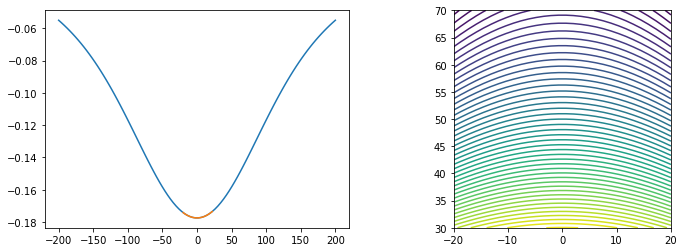

In [9]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))

x1 = np.linspace(-200, 200, 100) * 1e-6
y1 = np.linspace(-20, 20, 30) * 1e-6
z1 = np.linspace(-20, 20, 30) * 1e-6 + trap.z0

potential = trap.potential(voltages, x1, 0, trap.z0)

ax.plot(x1 * 1e6, potential)
ax.plot(x * 1e6, pot)

Y, Z = np.meshgrid(y1, z1)
ps = trap.potential(voltages, 0, Y, Z)
ax1.contour(Y * 1e6, Z * 1e6, ps, 50)
ax1.set_aspect(1)



This is clearly not sufficient to trap. Alternatives
- Reduce the size of the fittin region. We really want our trap to make a 200 um harmonic well, maybe we're asking to much. Try it yourself.
- Add objectives for the radials

## Fit 3D
Here I'd like to build the ellipsoid that has the axial and radial curvatures that I want.
Without radial mode rotation (a.k.a. tilt) is easy. I do think it's possible also with tilt but not quite sure how now.

In [10]:
# I'll just guess some frequencies that I know are reasonable for this trap, since it's basically a subset of the Cryo one
axial = freq_to_curv(1e6)
r1 = freq_to_curv(3.5e6)
r2 = freq_to_curv(6.5e6)


x0 = 0

# TRICK: leave the offset floating by letting the optimizer vary it
offset = cx.Variable()
offset.value = 0
# offset = 0

x = np.arange(-30, 32, 4) * 1e-6
y = np.arange(-20, 21, 2) * 1e-6
z = np.arange(-20, 21, 2) * 1e-6  # don't put z0 here

curv = np.diag([axial, r1, r2])

rtilt = cx.Variable()
rtilt = freq_to_curv(2e6)
curv[1, 2] = curv[2, 1] = rtilt

# There must be a more elegant way than meshgrid + ravel + stack
# But it works so let's go for it
R = np.meshgrid(x, y, z, indexing='ij')  # First axis is X, Y, Z. please always use ij with 3d data
R = np.stack(list(map(np.ravel, R)), axis=0)
X, Y, Z = R

pot = 0.5 * np.diag(R.T @ curv @ R) + offset
pot.shape


# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [obj.PotentialObjective(pot, X, Y, Z + trap.z0)]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     r2 >= freq_to_curv(2e6)
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value[0]  # let's just take the one sample


(6,) [ 9.99999664 -9.98618192  9.99999664 -3.26086188  0.4478002  -3.26086188]
[{'0_PotentialObjective': [Expression(CONVEX, NONNEGATIVE, ())]},
 {'0_global_VoltageObjective': [Expression(CONVEX, NONNEGATIVE, ())],
  '1_global_VoltageObjective': [Expression(CONVEX, NONNEGATIVE, ())]}]


In [11]:
from scipy.optimize import minimize

def find_3dmin(trap, voltages, r0, **kwargs):

    def fun3(xyz):
        return trap.potential(voltages, *xyz)
    print('--------------\n' "Analyse potential")
    res = minimize(fun3, r0, method='TNC', **kwargs)
    return res

In [12]:
r0 = 0, 0, trap.z0
_roi = x, y, z
bounds = [(r.min() + x, r.max() + x) for r, x in zip(_roi, r0)]
kwargs = dict(bounds=bounds, options=dict(accuracy=1e-12))

res = find_3dmin(trap, voltages, r0, **kwargs)

--------------
Analyse potential


In [13]:
res

     fun: -0.08345718303601757
     jac: array([ 3.02172888e-01, -2.61617757e+03,  1.39106662e-01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 288
     nit: 12
  status: 1
 success: True
       x: array([-1.23042397e-09,  2.00000000e-05,  4.52646689e-05])

-0.12280696584930824


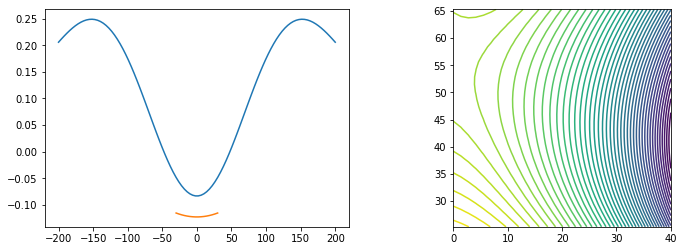

In [14]:
x0, y0, z0 = res.x if res.success else r0
try:
    offset = offset.value
except AttributeError:
    pass
print(offset)
pot_x = 0.5 * axial * (x - x0)**2 + offset

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))

x1 = np.linspace(-200, 200, 100) * 1e-6 + x0
y1 = np.linspace(-20, 20, 30) * 1e-6 + y0
z1 = np.linspace(-20, 20, 30) * 1e-6 + z0

potential = trap.potential(voltages, x1, y0, z0)

ax.plot(x1 * 1e6, potential)
ax.plot(x * 1e6, pot_x)

Y1, Z1 = np.meshgrid(y1, z1)
ps = trap.potential(voltages, 0, Y1, Z1)
ax1.contour(Y1 * 1e6, Z1 * 1e6, ps, 50)
ax1.set_aspect(1)



Well... good luck with that!